In [92]:
!pip install pillow requests scikit-image torchvision lime

     |████████████████████████████████| 275 kB 1.3 MB/s eta 0:00:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached scikit_learn-0.24.2-cp36-cp36m-manylinux2010_x86_64.whl (22.2 MB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached importlib_resources-5.4.0-py3-none-any.whl (28 kB)
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=be6fd7fd60d50c9a93c5224e372447178df7c42b86c4f6fb01805106410f15b2
  Stored in directory: /home/ivan/.cache/pip/wheels/52/f4/97/327dcd53a8b5e3a9d97111dccbdb4f51a7b644af686dac5088
Successfully built lime


In [8]:
# IMPORT LIBS
from PIL import Image
import requests
from skimage.segmentation import quickshift
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms
import json
import os
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch 
from tqdm import tqdm
import copy 



In [9]:
# LOAD IMAGE
url = 'https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_3x2.jpg'

im = Image.open(requests.get(url, stream=True).raw)
image = im.resize((256,256))

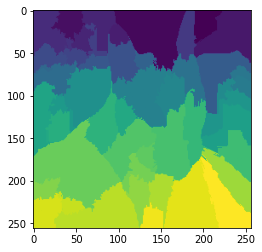

In [10]:
# 1. CREATE SUPERPIXELS
# Data labels
segmentation = quickshift(image, convert2lab=True, kernel_size=4, max_dist=200, ratio=0.2)

plt.imshow(segmentation)



In [11]:
# 2. GET PREDICTIONS FROM MODEL
model = models.inception_v3(pretrained=True)

## Transforms
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))} 


def pil_transform(x): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf(x)

def preprocess_transform(x):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf(x)

## Transforms 2
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def predict_model(x):
    return batch_predict(x)

In [12]:
# CREATE SIMPIFIED FEATURES
# used to sample superpixels
# Number of saples for interpretable data
n_samples = 100
# Number of superpixels used
n_superpixels = 3


n_features = np.max(segmentation)
data = np.random.randint(0,2, n_samples * n_features).reshape((n_samples, n_features))

In [19]:
# GET PREDICTION FOR COMBINATION OF SUPERPIXELS
data[0,:] = 1

batch_size = 10
original_image = np.array(image)

imgs = []
labels = []
for row in tqdm(data):

    image_copy = copy.deepcopy(original_image)
    mask = np.zeros(segmentation.shape).astype(bool)
    
    zeros = np.where(row==0)[0]
    for index in zeros:
        mask[segmentation==index] = True
    image_copy[mask] = original_image[mask]
    imgs.append(image_copy)

    if len(imgs) == batch_size:
        preds = predict_model(np.array(imgs))
        labels.extend(preds)
        imgs = []

# data, np.array(labels)


100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


(array([[1, 1, 1, ..., 1, 1, 1],
        [0, 1, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 0, 1, ..., 0, 1, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]]),
 array([[1.82158203e-06, 2.36840924e-06, 2.53828989e-06, ...,
         2.04196499e-06, 1.10267965e-05, 1.47441178e-05],
        [1.82158203e-06, 2.36840924e-06, 2.53828989e-06, ...,
         2.04196499e-06, 1.10267965e-05, 1.47441178e-05],
        [1.82158203e-06, 2.36840924e-06, 2.53828989e-06, ...,
         2.04196499e-06, 1.10267965e-05, 1.47441178e-05],
        ...,
        [1.82158203e-06, 2.36840924e-06, 2.53828989e-06, ...,
         2.04196499e-06, 1.10267965e-05, 1.47441178e-05],
        [1.82158146e-06, 2.36840856e-06, 2.53828671e-06, ...,
         2.04196635e-06, 1.10267929e-05, 1.47441133e-05],
        [1.82158146e-06, 2.36840856e-06, 2.53828671e-06, ...,
         2.04196635e-06, 1.10267929e-05, 1.47441133e-05]], dtype=float32))

In [13]:
# MEASURE DISTANCE BETWEEN PREDICTIONS
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric='cosine'
        ).ravel()
distances.shape

In [ ]:
# IMG EXPLANATION
from lime.lime_image import ImageExplanation
ret_exp = ImageExplanation(image, segmentation)

In [ ]:
top_labels = True
if top_labels:
    top = np.argsort(labels[0])[-top_labels:]
    ret_exp.top_labels = list(top)
    ret_exp.top_labels.reverse()
for label in top:
    (ret_exp.intercept[label],
        ret_exp.local_exp[label],
        ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(
        data, labels, distances, label, n_features,
        model_regressor=model_regressor,
        feature_selection=self.feature_selection)

## Below this line just unconnected snippets
---

In [4]:
# COMPUTE SIMM SCORE TO THE ORIGINAL IMAGE
def get_perturbation(image, mask, id):
    np_image = np.array(image)
    cond = mask != id
    np_image[cond] = 255//2
    return  Image.fromarray(np_image)

original_image = np.array(image)

ssim_scores = []
for i in range(np.max(masks)):
    superpixel = np.array(get_perturbation(image, masks, i))

    ssim_scores += [ssim(original_image, superpixel, multichannel=True)]
ssim_scores

[0.14741370777646193,
 0.19501072359344376,
 0.14383463020679796,
 0.1675800838291578,
 0.13908424189427904,
 0.15191995302072003,
 0.1501167164151519,
 0.13683211389686753,
 0.146970736995127,
 0.13751616963242366,
 0.1384936977864847,
 0.14166006586218058,
 0.15126378338785013,
 0.14020296995894851,
 0.16399629628686016,
 0.1409333087638739,
 0.1368321017745994,
 0.1440092530398935,
 0.15160728727030323,
 0.13725253552109673,
 0.13861073055182763,
 0.17526978949716632,
 0.15074787814543153,
 0.13742546516044243,
 0.17572015448246403,
 0.14594745990549415,
 0.13807307941364635,
 0.15282879638097593,
 0.15176222050821683,
 0.14232613172795835,
 0.14513411404743953,
 0.15100131150619553,
 0.15931672015845696,
 0.15050419740976237,
 0.1570806243204353,
 0.15498554255486433,
 0.13827327504277767,
 0.19797087124271903,
 0.13744141077268965,
 0.1431245177518848,
 0.13939196935467388,
 0.15537313590705326,
 0.1429148134069382,
 0.16558959813140134,
 0.14285611249303506,
 0.14831248070958494,

In [7]:
test_pred = batch_predict([pill_transf(im)])
test_pred.squeeze().argmax()

285

In [ ]:

###
###
###


predictions_scores = []
for i in range(np.max(masks)):
    superpixel = get_perturbation(image, masks, i)

    img_t = get_input_tensors(superpixel)
    model.eval()
    logits = model(img_t)

    probs = F.softmax(logits, dim=1)
    probs5 = probs.topk(1)
    pred = tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))
    pred = pred
    predictions_scores += [pred]


In [91]:
labels = np.array(predictions_scores)[:,:,1].astype(int)
labels

array([[667],
       [382],
       [ 23],
       [ 23],
       [325],
       [983],
       [ 23],
       [701],
       [657],
       [895],
       [701],
       [405],
       [ 89],
       [983],
       [667],
       [ 78],
       [306],
       [ 23],
       [ 21],
       [677],
       [948],
       [308],
       [984],
       [306],
       [667],
       [843],
       [895],
       [ 21],
       [ 23],
       [952],
       [920],
       [  5],
       [128],
       [845],
       [  7],
       [948],
       [325],
       [186],
       [325],
       [738],
       [552],
       [ 21],
       [862],
       [112],
       [316],
       [266],
       [ 21],
       [470]])

In [ ]:
from tqdm import tqdm
progress_bar = 1
import copy
segments = masks
fudged_image = original_image

rows = tqdm(data) if progress_bar else data
for row in rows:
    temp = copy.deepcopy(image)
    zeros = np.where(row == 0)[0]
    mask = np.zeros(segments.shape).astype(bool)
    for z in zeros:
        mask[segments == z] = True
    temp[mask] = fudged_image[mask]
    imgs.append(temp)
    if len(imgs) == batch_size:
        preds = classifier_fn(np.array(imgs))
        labels.extend(preds)
        imgs = []
if len(imgs) > 0:
    preds = classifier_fn(np.array(imgs))
    labels.extend(preds)

In [63]:
predictions_scores

[((0.68010676, 417, 'balloon'),
  (0.07726014, 667, 'mortarboard'),
  (0.05088229, 879, 'umbrella'),
  (0.038433857, 96, 'toucan'),
  (0.027330246, 701, 'parachute')),
 ((0.04264286, 749, 'quill'),
  (0.035023414, 667, 'mortarboard'),
  (0.02743576, 400, 'academic_gown'),
  (0.026451433, 879, 'umbrella'),
  (0.014971901, 465, 'bulletproof_vest')),
 ((0.08616761, 465, 'bulletproof_vest'),
  (0.078672625, 796, 'ski_mask'),
  (0.051813375, 615, 'knee_pad'),
  (0.031695124, 399, 'abaya'),
  (0.027917508, 23, 'vulture')),
 ((0.06571881, 350, 'ibex'),
  (0.06460861, 331, 'hare'),
  (0.064360626, 51, 'triceratops'),
  (0.051505346, 30, 'bullfrog'),
  (0.049277566, 134, 'crane')),
 ((0.48713264, 171, 'Italian_greyhound'),
  (0.2036829, 172, 'whippet'),
  (0.070818424, 719, 'piggy_bank'),
  (0.024771273, 353, 'gazelle'),
  (0.014145732, 331, 'hare')),
 ((0.52866906, 140, 'red-backed_sandpiper'),
  (0.13396747, 141, 'redshank'),
  (0.047917828, 94, 'hummingbird'),
  (0.037204474, 128, 'black_sto

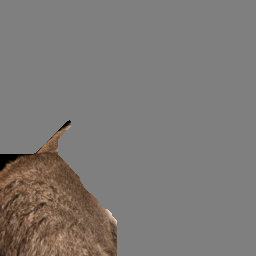

In [64]:
superpixel

In [27]:
# # np.unique(results)

       
# for i in range(1,30, 5):
#     perturb = get_perturbation(im, masks, i)
#     plt.imshow(perturb)
#     plt.show()

In [154]:
img_t = get_input_tensors(im)
model.eval()
logits = model(img_t)

In [8]:

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
r = tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [16]:

[x for x in np.array(r)[:,2]]

['Egyptian_cat', 'tabby', 'tiger_cat', 'lynx', 'Siamese_cat']

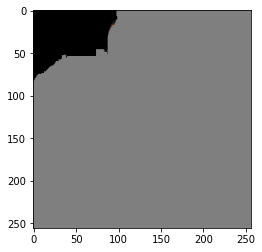

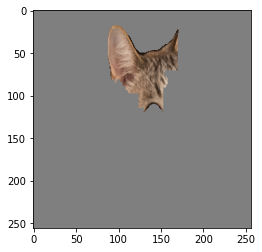

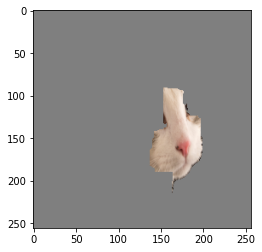

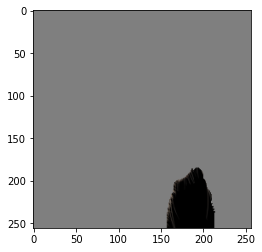

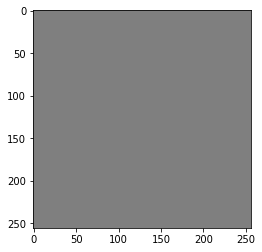

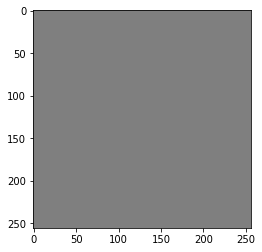

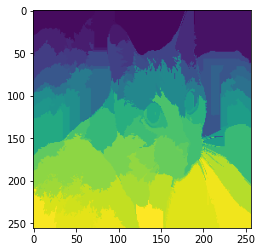

In [69]:
results = quickshift(im, sigma=0)
plt.imshow(results)
# for i in range(5):
#     results = quickshift(im, ratio=i/10)
#     plt.imshow(results)
#     plt.show()

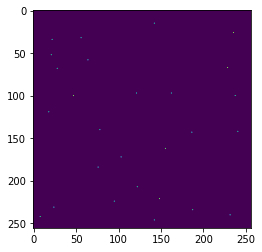

In [64]:

a = np.array(results[0])
b = np.array(results[1])
c = np.array(results[2])
plt.imshow(c)

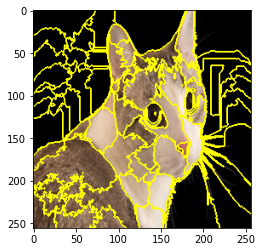

In [47]:
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 

mask = results

# positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(im, mask)
plt.imshow(img_boundry1)